# Image Classification using CNNs for GTSRB Dataset

The German Traffic Sign Recognition Benchmark (GTSRB) dataset is widely used in computer vision and machine learning. The dataset consists of images of various traffic signs commonly found in Germany, including speed limit signs, yield signs, stop signs, and many others. These images are captured under different lighting conditions, weather conditions, and viewpoints, making it challenging for algorithms to accurately classify and recognize the signs. The classification dataset contains **43 classes of German traffic signs.** The entire dataset (Train and Test) contains over 50,000 images.

Table of Contents

1. [Download and Extract the Dataset](#Download-and-Extract-the-Dataset)
2. [Dataset and Training Configuration](#Dataset-and-Training-Configuration)
3. [Prepare GTSRB Dataset](#prepare-gtsrb-dataset)
4. [Model Definition and Training](#model-definition-and-training)
5. [Plot Results](#plot-results)
6. [Evaluate in the Test Dataset](#evaluate-in-the-test-dataset)
7. [Using Spatial Transformer Layer](#using-spatial-transformer-layer)
8. [Evaluate using Test Dataset](#evaluate-using-test-dataset)


In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import os
import gc
import torch

import numpy as np
import seaborn as sns
import torchvision as tv
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

from dataclasses import dataclass

from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassConfusionMatrix,
    MulticlassRecall,
    MulticlassPrecision,
)

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download and Extract the Dataset


In [5]:
train_dataset = tv.datasets.GTSRB(root="./data", split="train", download=True)
tests_dataset = tv.datasets.GTSRB(root="./data", split="test", download=True)

## Dataset and Training Configuration


Here we can use the Python dataclasses module to create two classes to configure data and training hyperparameters conveniently


In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT: int = 64
    WIDTH: int = 64
    CHANNELS: int = 3
    NUM_CLASSES: int = 43


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 32
    EPOCHS: int = 30
    LEARNING_RATE: float = 3e-3
    WEIGHT_DECAY: float = 1e-5
    NUM_WORKERS: int = 0
    BREAK_AFTER_IT = None
    ROOT_DIR: str = "./"

The following is the mapping of the class id's to their actual class names


In [7]:
classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing veh over 3.5 tons",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Veh > 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End speed + passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End no passing veh > 3.5 tons",
}

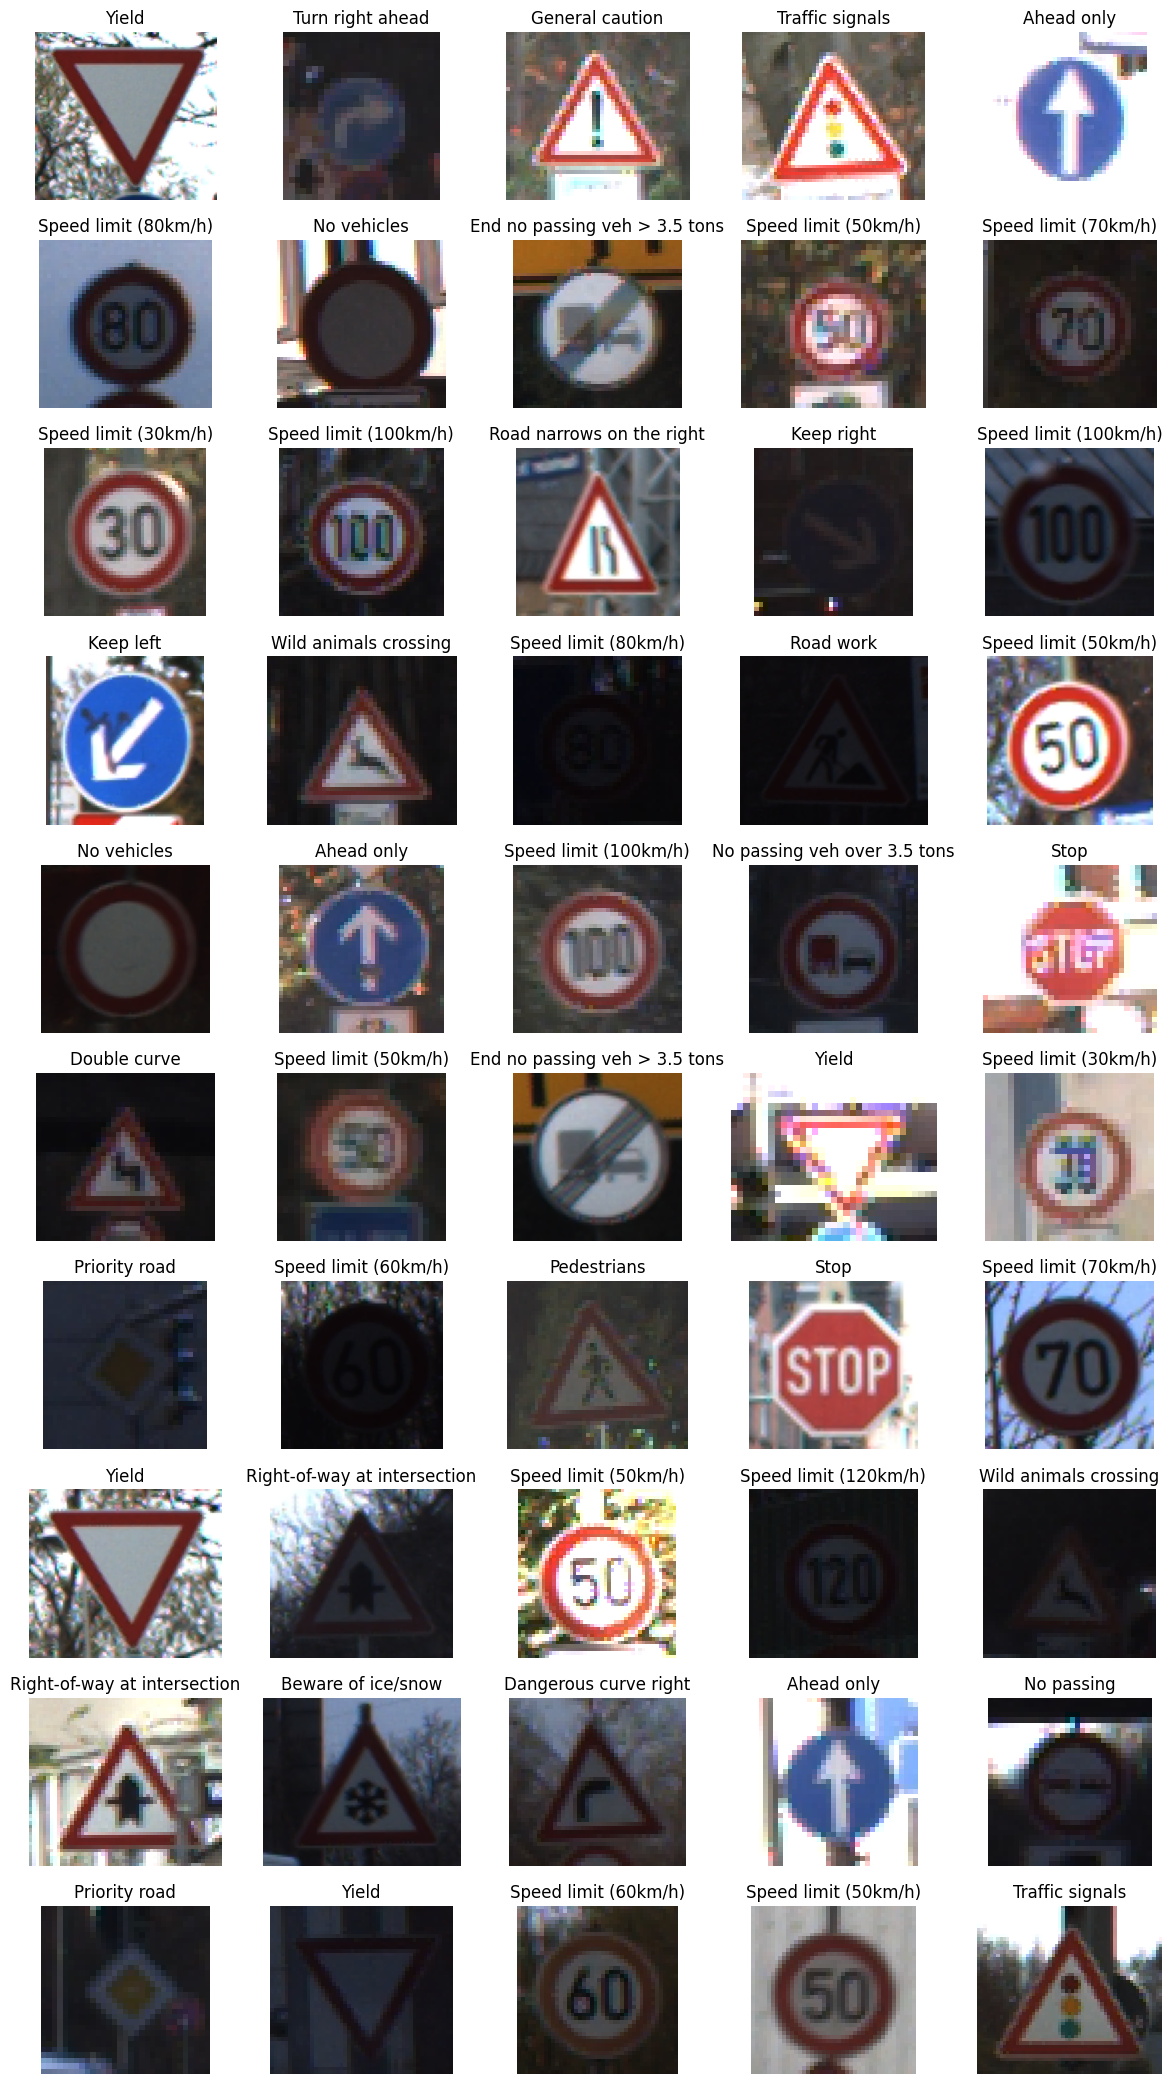

In [8]:
plt.subplots(10, 5, figsize=(12, 21))
for i in range(50):
    image = train_dataset[np.random.randint(len(train_dataset))]
    plt.subplot(10, 5, i + 1)
    plt.title(classes[image[1]])
    plt.imshow(image[0])
    plt.axis("off")
plt.tight_layout(pad=1.27)

Since we are dealing with a unbalanced dataset we most estimate the weights of each class this is done with the following formula.

$$
weights = \frac{\sum_{k=1}^n freq}{classes * freq}
$$

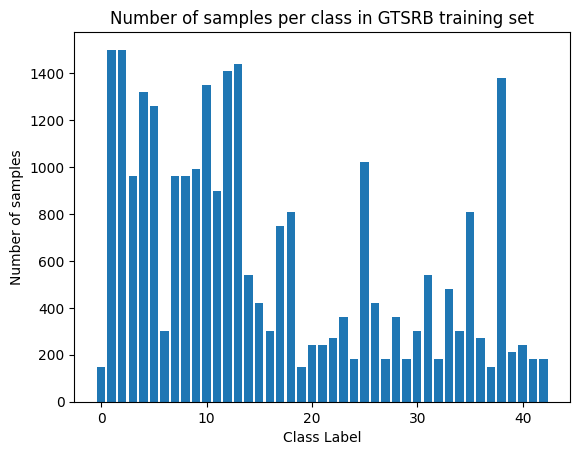

In [9]:
freq = np.bincount([label for _, label in train_dataset])
weights = torch.tensor(np.sum(freq) / (len(classes) * freq), dtype=torch.float32)

plt.bar(np.arange(len(freq)), freq)
plt.xlabel("Class Label")
plt.ylabel("Number of samples")
plt.title("Number of samples per class in GTSRB training set")
plt.show()

## Prepare GTSRB Dataset


Apply the standard transformations:

 - Resize
 - Converto to PIL Image
 - Scale from [0, 255] to [0, 1]
 - Convert to torch tensor

In [10]:
def get_preprocess_transforms(resize_to=(32, 32)):
    transforms = v2.Compose(
        [
            v2.Resize(resize_to),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.PILToTensor(),
        ]
    )
    return transforms

And then applying a normalization mean and std factor, by default set to imagenet mean and std.

In [11]:
def get_common_transforms(
    resize_to, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
):
    preprocess = get_preprocess_transforms(resize_to=resize_to)

    common_transforms = v2.Compose([preprocess, v2.Normalize(mean, std)])

    return common_transforms

Calculation of the mean and std of the dataset over the batches of the training dataset

In [12]:
def get_mean_std(dataset, resize_to=(32, 32), batch_size=128, num_workers=4):

    pre_transforms = get_preprocess_transforms(resize_to=resize_to)
    dataset.transform = pre_transforms
    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    batch_mean = torch.zeros(DatasetConfig.CHANNELS)
    batch_mean_sq = torch.zeros(DatasetConfig.CHANNELS)

    for batch_data, _ in tqdm(
        iterable=data_loader,
        ascii=True,
        total=len(data_loader),
        desc="Computing MEAN & STD",
    ):
        batch_mean += torch.mean(batch_data, dim=(0, 2, 3))
        batch_mean_sq += torch.mean(batch_data**2, dim=(0, 2, 3))

    mean = batch_mean / len(data_loader)
    # var[X] = E[X**2] - E[X]**2
    var = (batch_mean_sq / len(data_loader)) - (mean**2)
    std = var**0.5

    print("Mean: {}, Std: {}".format(mean, std))

    return mean, std

Create a function to return the train, valid and test dataloader with the common and augmentation transforms

In [13]:
def get_data(
    dataset,
    tests_dataset,
    resize_to=(32, 32),
    batch_size=32,
    data_augmentation=False,
    num_workers=0,
):

    MEAN = 0
    STD = 1

    MEAN, STD = get_mean_std(dataset, resize_to=resize_to, num_workers=2)

    common_transforms = get_common_transforms(resize_to=resize_to, mean=MEAN, std=STD)

    if data_augmentation:

        transforms = v2.Compose(
            [
                common_transforms,
                v2.RandomChoice(
                    [
                        v2.RandomAffine(degrees=(-25, 25)),
                        v2.RandomAffine(translate=(0.2, 0.2), degrees=(0, 0)),
                        v2.RandomAffine(scale=(0.90, 1.1), degrees=(0, 0)),
                    ]
                ),
            ]
        )
    else:
        transforms = common_transforms

    train_dataset, valid_dataset = torch.utils.data.random_split(
        dataset, lengths=(0.7, 0.3)
    )

    train_dataset.transform = transforms  # type: ignore
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    valid_dataset.transform = transforms  # type: ignore
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    tests_dataset.transform = transforms  # type: ignore
    tests_dataloader = DataLoader(
        tests_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_dataloader, valid_dataloader, tests_dataloader

In [14]:
train_dataloader, valid_dataloader, test_dataloader = get_data(
    train_dataset,
    tests_dataset,
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    data_augmentation=False,
)

Computing MEAN & STD: 100%|##########| 209/209 [00:12<00:00, 16.26it/s] 

Mean: tensor([0.3410, 0.3119, 0.3209]), Std: tensor([0.2761, 0.2638, 0.2697])


## Model Definition and Training


As baseline we use the standard Convolutional, Batch Normalization, ReLU and MaxPool layers to form a CBRBlock with this block we will create the backbone of our model.

After each forward pass the spatial dimensions are reduced by the half and increasing the channel dimension creating a feature volume. The main classifier is a standard MLP (Multilayer Perceptron) of one hidden layer relu activation function and dropout to avoid overfitting.

For weight initialization we use xavier for Linear layers, kaiming he for convolutional layers and a normal distribution for batch normalization layers


In [15]:
class CBRBlock(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size) -> None:
        super().__init__()
        self.model_ = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, X):
        return self.model_(X)

In [16]:
class SignNet(torch.nn.Module):

    def __init__(self, in_channels, num_classes, dropout_rate=0.5) -> None:
        super().__init__()

        self.model_ = torch.nn.Sequential(
            CBRBlock(in_channels, 32, 3),
            CBRBlock(32, 64, 3),
            CBRBlock(64, 128, 3),
            CBRBlock(128, 256, 3),
            CBRBlock(256, 512, 3),
            torch.nn.AdaptiveMaxPool2d(output_size=(1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=512, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(in_features=256, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(in_features=128, out_features=num_classes),
        )

    def forward(self, input):
        x = self.model_(input)
        return x

In [17]:
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        # Xavier uniform initialization for linear layers
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Conv2d):
        # Kaiming uniform initialization (He initialization) for Conv2d layers
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        # BatchNorm layers are often initialized differently
        torch.nn.init.normal_(m.weight, mean=1.0, std=0.02)
        torch.nn.init.zeros_(m.bias)

In [18]:
model = SignNet(
    in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES
)

model.apply(initialize_weights)

summary(
    model,
    depth=2,
    col_names=["input_size", "output_size", "num_params"],
    input_data=torch.ones(
        TrainingConfig.BATCH_SIZE,
        DatasetConfig.CHANNELS,
        DatasetConfig.HEIGHT,
        DatasetConfig.WIDTH,
    ),
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SignNet                                  [32, 3, 64, 64]           [32, 43]                  --
├─Sequential: 1-1                        [32, 3, 64, 64]           [32, 43]                  --
│    └─CBRBlock: 2-1                     [32, 3, 64, 64]           [32, 32, 32, 32]          960
│    └─CBRBlock: 2-2                     [32, 32, 32, 32]          [32, 64, 16, 16]          18,624
│    └─CBRBlock: 2-3                     [32, 64, 16, 16]          [32, 128, 8, 8]           74,112
│    └─CBRBlock: 2-4                     [32, 128, 8, 8]           [32, 256, 4, 4]           295,680
│    └─CBRBlock: 2-5                     [32, 256, 4, 4]           [32, 512, 2, 2]           1,181,184
│    └─AdaptiveMaxPool2d: 2-6            [32, 512, 2, 2]           [32, 512, 1, 1]           --
│    └─Flatten: 2-7                      [32, 512, 1, 1]           [32, 512]                 --
│    └─Linear:

In [19]:
def train_model(
    model,
    config,
    optimizer: torch.optim.Optimizer,
    criterion,
    scheduler,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    device,
    train_metrics: list,
    valid_metrics: list,
    early_stopping=None,
    model_name=None,
    checkpoint_path=None,
    break_after_it=None,
):
    train_results = []
    valid_results = []

    N = config.EPOCHS * len(train_dataloader) + config.EPOCHS * len(valid_dataloader)
    progress = tqdm(total=N, desc="Training Progress", leave=True)

    scaler = torch.amp.GradScaler(device)  # type: ignore

    model = model.to(device)
    train_loss = float("inf")
    val_loss = float("inf")

    for epoch in range(config.EPOCHS):

        for metric in train_metrics:
            metric.reset()

        model.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            if device == "cuda":
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

            train_loss = loss.item() / inputs.size(0)

            pred = torch.argmax(outputs, dim=1)

            for metric in train_metrics:
                metric.update(pred.cpu(), labels.cpu())

            metrics = {
                f"Train{metric.__class__.__name__}": f"{metric.compute():.4f}"
                for metric in train_metrics
            }

            progress.set_postfix(
                {
                    "epoch": f"{epoch + 1}",
                    "loss": f"{train_loss:.4f}",
                    "val_loss": f"{val_loss:.4f}",
                    **metrics,
                    "lr": f"{scheduler.get_last_lr()[0]:.6f}",
                }
            )

            train_results.append(
                [epoch + ((i + 1) / len(train_dataloader)), train_loss]
                + [metric.compute() for metric in train_metrics]
            )

            progress.update(1)

            if break_after_it is not None and i > break_after_it:
                break

        model.eval()
        for i, batch in enumerate(valid_dataloader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss = loss.item()

            pred = torch.argmax(outputs, dim=1)

            for metric in valid_metrics:
                metric.update(pred.cpu(), labels.cpu())

            metrics = {
                f"Valid{metric.__class__.__name__}": f"{metric.compute():.4f}"
                for metric in valid_metrics
            }

            progress.set_postfix(
                {
                    "epoch": f"{epoch + 1}",
                    "loss": f"{train_loss:.4f}",
                    "val_loss": f"{val_loss:.4f}",
                    **metrics,
                    "lr": f"{scheduler.get_last_lr()[0]:.6f}",
                }
            )

            valid_results.append(
                [epoch + ((i + 1) / len(valid_dataloader)), val_loss]
                + [metric.compute() for metric in valid_metrics]
            )

            progress.update(1)

            if break_after_it is not None and i > break_after_it:
                break

        if (
            break_after_it is None
            and model_name is not None
            and checkpoint_path is not None
        ):
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": model.state_dict(),
                "loss": train_loss,
            }

            torch.save(checkpoint, os.path.join(checkpoint_path, model_name))

        if early_stopping is not None:
            early_stopping.check_early_stop(val_loss)

            if early_stopping.stop_training:
                print(f"Early stopping in epoch: {epoch}")
                break

        if break_after_it is not None:
            break

    # Cleanup
    del model
    del optimizer
    del train_dataloader
    del valid_dataloader

    gc.collect()
    torch.cuda.empty_cache()

    return train_results, valid_results

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                self.stop_training = True

### Training details

For training the model we opt for using an AdamW optimizer with regularization parameter, CrossEntropyLoss with label smoothing allowing us to prevent the model from becoming too confident by slightly modifying the one-hot labels into soft targets, the scheduler is a OneCycleLR which allow us to escape from local minima in the first iterations and subsecuently finding a better minima.


In [21]:
device = get_default_device()

model = SignNet(in_channels=3, num_classes=len(classes))
optim = torch.optim.AdamW(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    weight_decay=TrainingConfig.WEIGHT_DECAY,
)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=TrainingConfig.LEARNING_RATE,
    steps_per_epoch=len(train_dataloader),
    epochs=TrainingConfig.EPOCHS,
)
early_stopping = None
train_metrics = [
    MulticlassAccuracy(average="micro", num_classes=DatasetConfig.NUM_CLASSES)
]

valid_metrics = [
    MulticlassAccuracy(average="micro", num_classes=DatasetConfig.NUM_CLASSES)
]

train_results, valid_results = train_model(
    model,
    TrainingConfig(),
    optim,
    criterion,
    scheduler,
    train_dataloader,
    test_dataloader,
    device.type,
    early_stopping=early_stopping,
    train_metrics=train_metrics,
    valid_metrics=valid_metrics,
    break_after_it=TrainingConfig.BREAK_AFTER_IT,
    checkpoint_path=os.path.join(TrainingConfig.ROOT_DIR, "models"),
    model_name=SignNet.__name__ + ".checkpoint",
)

torch.save(
    model, os.path.join(TrainingConfig.ROOT_DIR, "models", SignNet.__name__ + ".pt")
)

Training Progress: 100%|██████████| 29340/29340 [07:07<00:00, 68.59it/s, epoch=30, loss=0.0900, val_loss=2.1148, ValidMulticlassAccuracy=0.7932, lr=0.000000] 


## Plot Results


Text(0.5, 1.0, 'Training and Validation Loss')

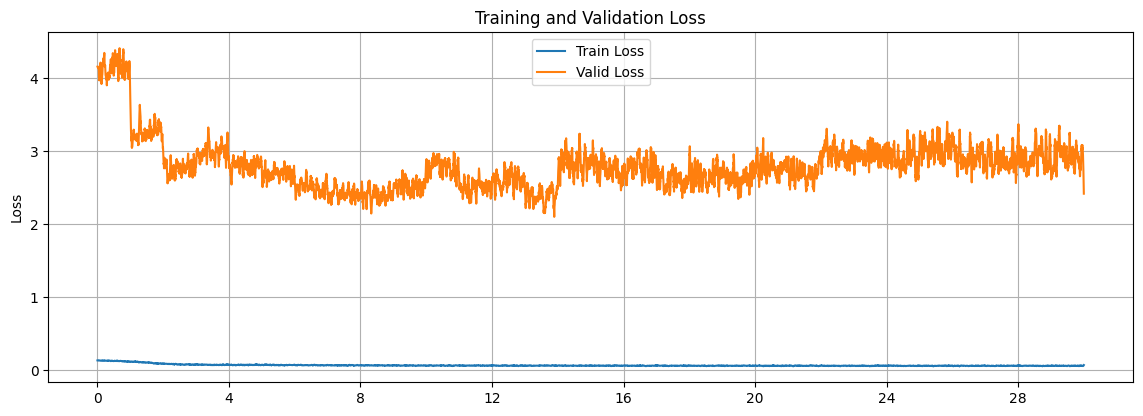

In [22]:
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)
window = 30
polyorder = 2


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    savgol_filter(train_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:blue",
    label="Train Loss",
)

plt.plot(
    valid_results_np[:, 0],
    savgol_filter(valid_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:orange",
    label="Valid Loss",
)

plt.ylabel("Loss")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Acc')

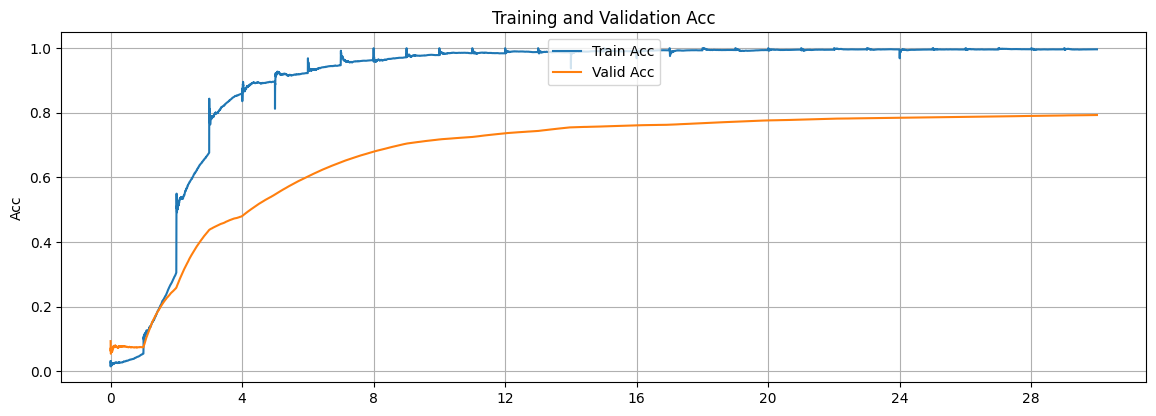

In [23]:
from matplotlib.ticker import MaxNLocator


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    train_results_np[:, 2],
    color="tab:blue",
    label="Train Acc",
)

plt.plot(
    valid_results_np[:, 0],
    valid_results_np[:, 2],
    color="tab:orange",
    label="Valid Acc",
)

plt.ylabel("Acc")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Acc")

## Evaluate in the Test Dataset


In [24]:
acc = MulticlassAccuracy(num_classes=len(classes), average="micro")
recall = MulticlassRecall(num_classes=len(classes), average="micro")
precision = MulticlassPrecision(num_classes=len(classes), average="micro")
confmat = MulticlassConfusionMatrix(num_classes=len(classes))

For evaluating the dataset we decided to use Accuracy, Recall and Precision.

 - Accuracy indicates the percentage of correct classifications
 - Recall indicates the percentage of successful identification of positive cases, minimizing missed opportunities
 - Precision indicates the percentage of all predicted classifications how many were truly positive.

Accuracy 0.831433117389679
Recall 0.831433117389679
Precision 0.831433117389679


<Axes: >

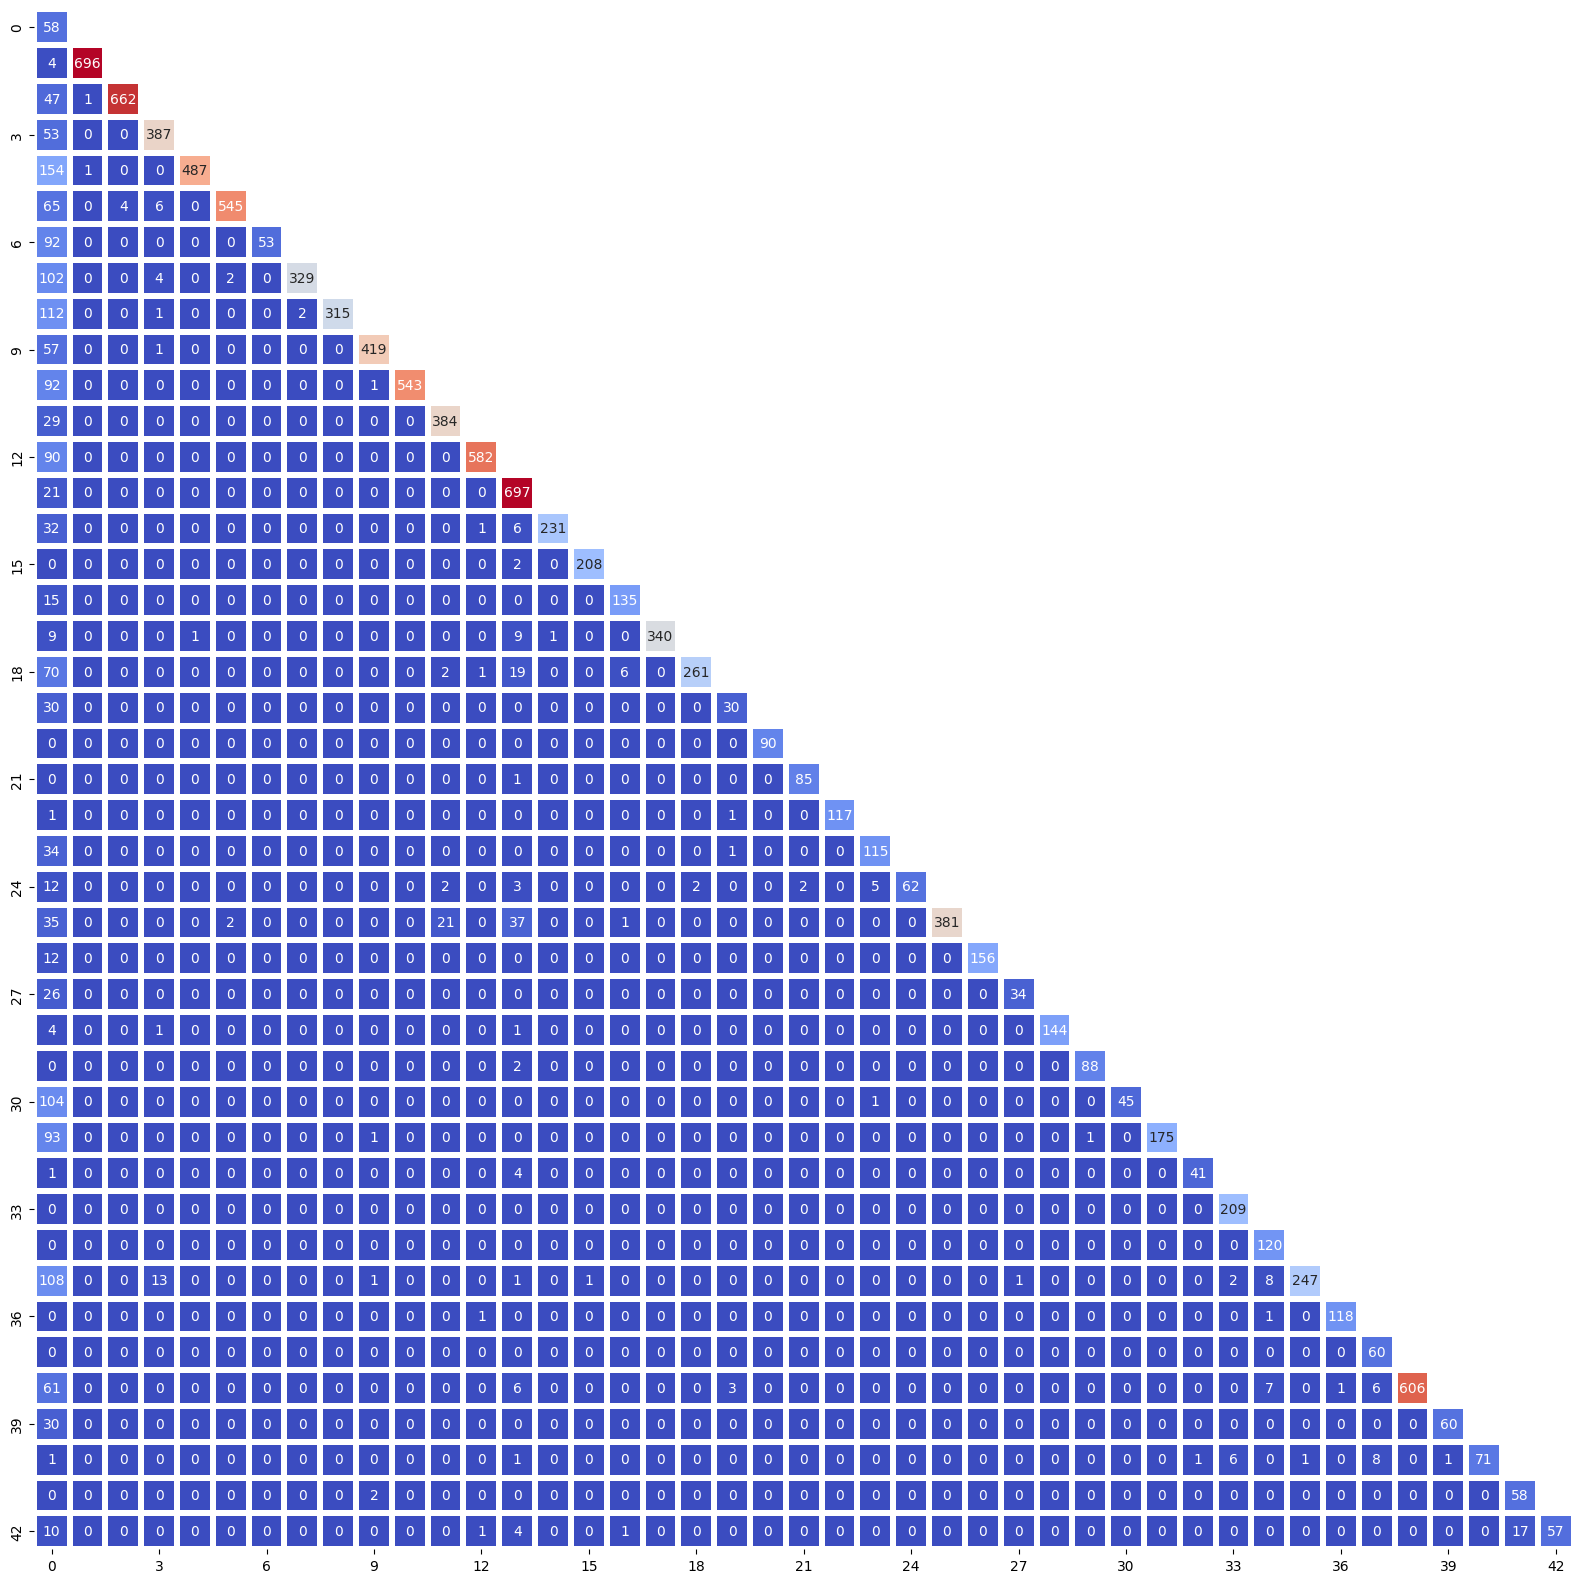

In [25]:
model.eval()
for batch in test_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    pred = torch.argmax(outputs, dim=1)

    acc.update(pred.cpu(), labels.cpu())
    recall.update(pred.cpu(), labels.cpu())
    precision.update(pred.cpu(), labels.cpu())
    confmat.update(pred.cpu(), labels.cpu())

print("Accuracy {}".format(acc.compute().item()))
print("Recall {}".format(recall.compute().item()))
print("Precision {}".format(precision.compute().item()))

matrix = confmat.compute().numpy()
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False


fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".0f",
    linewidths=3,
    cmap="coolwarm",
    ax=ax,
    cbar=False,
    xticklabels=3,
    yticklabels=3,
    square=True,
    mask=mask,
)

## Using Spatial Transformer Layer

The spatial transformer uses an affine grid for transforming the input image focusing the region of interest by rotating, scaling and translating.
The warp affine transformations are learned using a multilayer perceptron (MLP) and a convolutional neural network (CNN) for locating the features to be extracted.

In [26]:
train_dataloader, valid_dataloader, test_dataloader = get_data(
    train_dataset,
    tests_dataset,
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    data_augmentation=False,
)

Computing MEAN & STD: 100%|##########| 209/209 [00:14<00:00, 14.91it/s]

Mean: tensor([0.3410, 0.3119, 0.3209]), Std: tensor([0.2761, 0.2638, 0.2697])


In [27]:
class SpatialSignNet(torch.nn.Module):

    def __init__(self, in_channels, num_classes) -> None:
        super().__init__()
        self.signNet = SignNet(in_channels=in_channels, num_classes=num_classes)

        self.localization = torch.nn.Sequential(
            CBRBlock(in_channels, 8, kernel_size=7),
            CBRBlock(8, 16, kernel_size=5),
            CBRBlock(16, 32, kernel_size=5),
            CBRBlock(32, 64, kernel_size=5),
            CBRBlock(64, 128, kernel_size=5),
            torch.nn.AdaptiveMaxPool2d(output_size=(1, 1)),
        )

        self.fc_loc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128, 32),
            torch.nn.Dropout(p=0.4),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(32, 6),
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[-1].weight.data.zero_()  # type: ignore
        self.fc_loc[-1].bias.data.zero_()  # type: ignore
        self.fc_loc[-1].bias.data.copy_(
            torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32)
        )  # type: ignore

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 128)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def forward(self, input):
        x = self.stn(input)
        x = self.signNet(x)
        return F.log_softmax(x, dim=1)

In [28]:
model = SpatialSignNet(
    in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES
)


summary(
    model,
    depth=2,
    col_names=["input_size", "output_size", "num_params"],
    input_data=torch.ones(
        TrainingConfig.BATCH_SIZE,
        DatasetConfig.CHANNELS,
        DatasetConfig.HEIGHT,
        DatasetConfig.WIDTH,
    ),
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
SpatialSignNet                                [32, 3, 64, 64]           [32, 43]                  --
├─Sequential: 1-1                             [32, 3, 64, 64]           [32, 128, 1, 1]           --
│    └─CBRBlock: 2-1                          [32, 3, 64, 64]           [32, 8, 32, 32]           1,200
│    └─CBRBlock: 2-2                          [32, 8, 32, 32]           [32, 16, 16, 16]          3,248
│    └─CBRBlock: 2-3                          [32, 16, 16, 16]          [32, 32, 8, 8]            12,896
│    └─CBRBlock: 2-4                          [32, 32, 8, 8]            [32, 64, 4, 4]            51,392
│    └─CBRBlock: 2-5                          [32, 64, 4, 4]            [32, 128, 2, 2]           205,184
│    └─AdaptiveMaxPool2d: 2-6                 [32, 128, 2, 2]           [32, 128, 1, 1]           --
├─Sequential: 1-2                             [32, 128]            

In [29]:
device = get_default_device()

model = SpatialSignNet(in_channels=3, num_classes=DatasetConfig.NUM_CLASSES)
optim = torch.optim.SGD(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)
criterion = torch.nn.NLLLoss(weight=weights.to(device))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=TrainingConfig.LEARNING_RATE,
    steps_per_epoch=len(train_dataloader),
    epochs=TrainingConfig.EPOCHS,
)
early_stopping = None

train_metrics = [
    MulticlassAccuracy(average="micro", num_classes=DatasetConfig.NUM_CLASSES)
]

valid_metrics = [
    MulticlassAccuracy(average="micro", num_classes=DatasetConfig.NUM_CLASSES)
]

train_results, valid_results = train_model(
    model,
    TrainingConfig(),
    optim,
    criterion,
    scheduler,
    train_dataloader,
    test_dataloader,
    device.type,
    early_stopping=early_stopping,
    train_metrics=train_metrics,
    valid_metrics=valid_metrics,
    break_after_it=TrainingConfig.BREAK_AFTER_IT,
    checkpoint_path=os.path.join(TrainingConfig.ROOT_DIR, "models"),
    model_name=SpatialSignNet.__name__ + ".checkpoint",
)

torch.save(
    model,
    os.path.join(TrainingConfig.ROOT_DIR, "models", SpatialSignNet.__name__ + ".pt"),
)

Training Progress:   0%|          | 0/29340 [00:00<?, ?it/s]/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torch/autograd/graph.py:841: UserWarning: The operator 'aten::grid_sampler_2d_backward' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Progress: 100%|██████████| 29340/29340 [07:22<00:00, 66.25it/s, epoch=30, loss=0.0000, val_loss=0.8103, ValidMulticlassAccuracy=0.7295, lr=0.000000]


Text(0.5, 1.0, 'Training and Validation Loss')

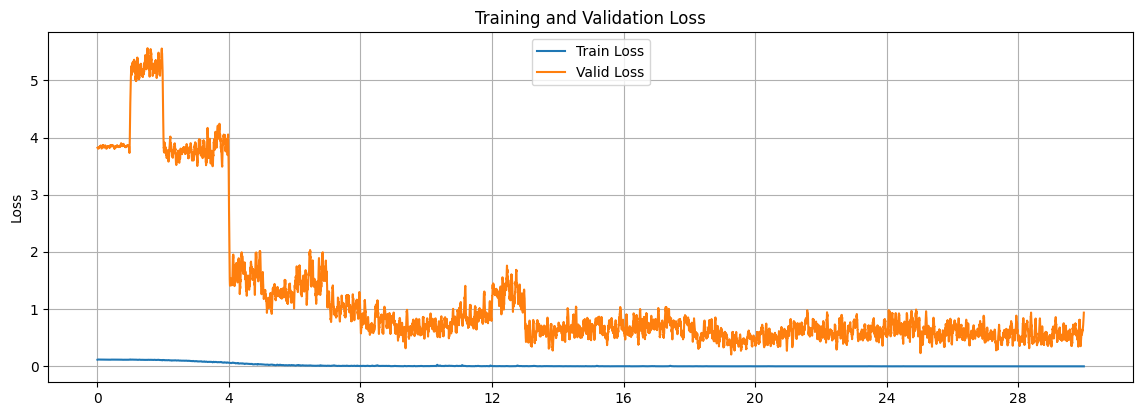

In [30]:
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)
window = 30
polyorder = 2


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    savgol_filter(train_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:blue",
    label="Train Loss",
)

plt.plot(
    valid_results_np[:, 0],
    savgol_filter(valid_results_np[:, 1], window_length=window, polyorder=polyorder),
    color="tab:orange",
    label="Valid Loss",
)

plt.ylabel("Loss")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Acc')

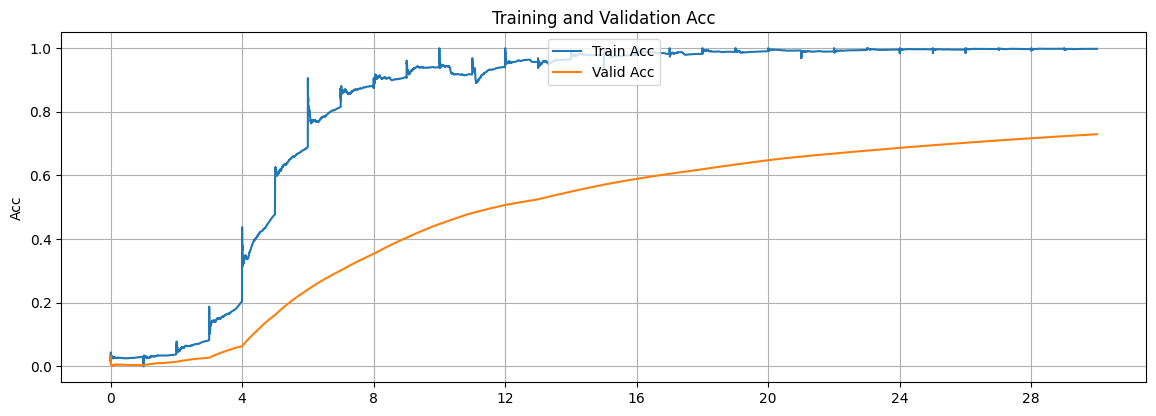

In [31]:
from matplotlib.ticker import MaxNLocator


train_results_np = np.array(train_results)
valid_results_np = np.array(valid_results)


plt.rcParams["figure.figsize"] = (14, 10)
fig = plt.figure()
fig.set_facecolor("white")


# plot loss
plt.subplot(2, 1, 1)

plt.plot(
    train_results_np[:, 0],
    train_results_np[:, 2],
    color="tab:blue",
    label="Train Acc",
)

plt.plot(
    valid_results_np[:, 0],
    valid_results_np[:, 2],
    color="tab:orange",
    label="Valid Acc",
)

plt.ylabel("Acc")
plt.legend(loc="upper center")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.title("Training and Validation Acc")

## Evaluate using test dataset

In [32]:
acc = MulticlassAccuracy(num_classes=len(classes), average="micro")
recall = MulticlassRecall(num_classes=len(classes), average="micro")
precision = MulticlassPrecision(num_classes=len(classes), average="micro")
confmat = MulticlassConfusionMatrix(num_classes=len(classes))

Accuracy 0.9024544954299927
Recall 0.9024544954299927
Precision 0.9024544954299927


<Axes: >

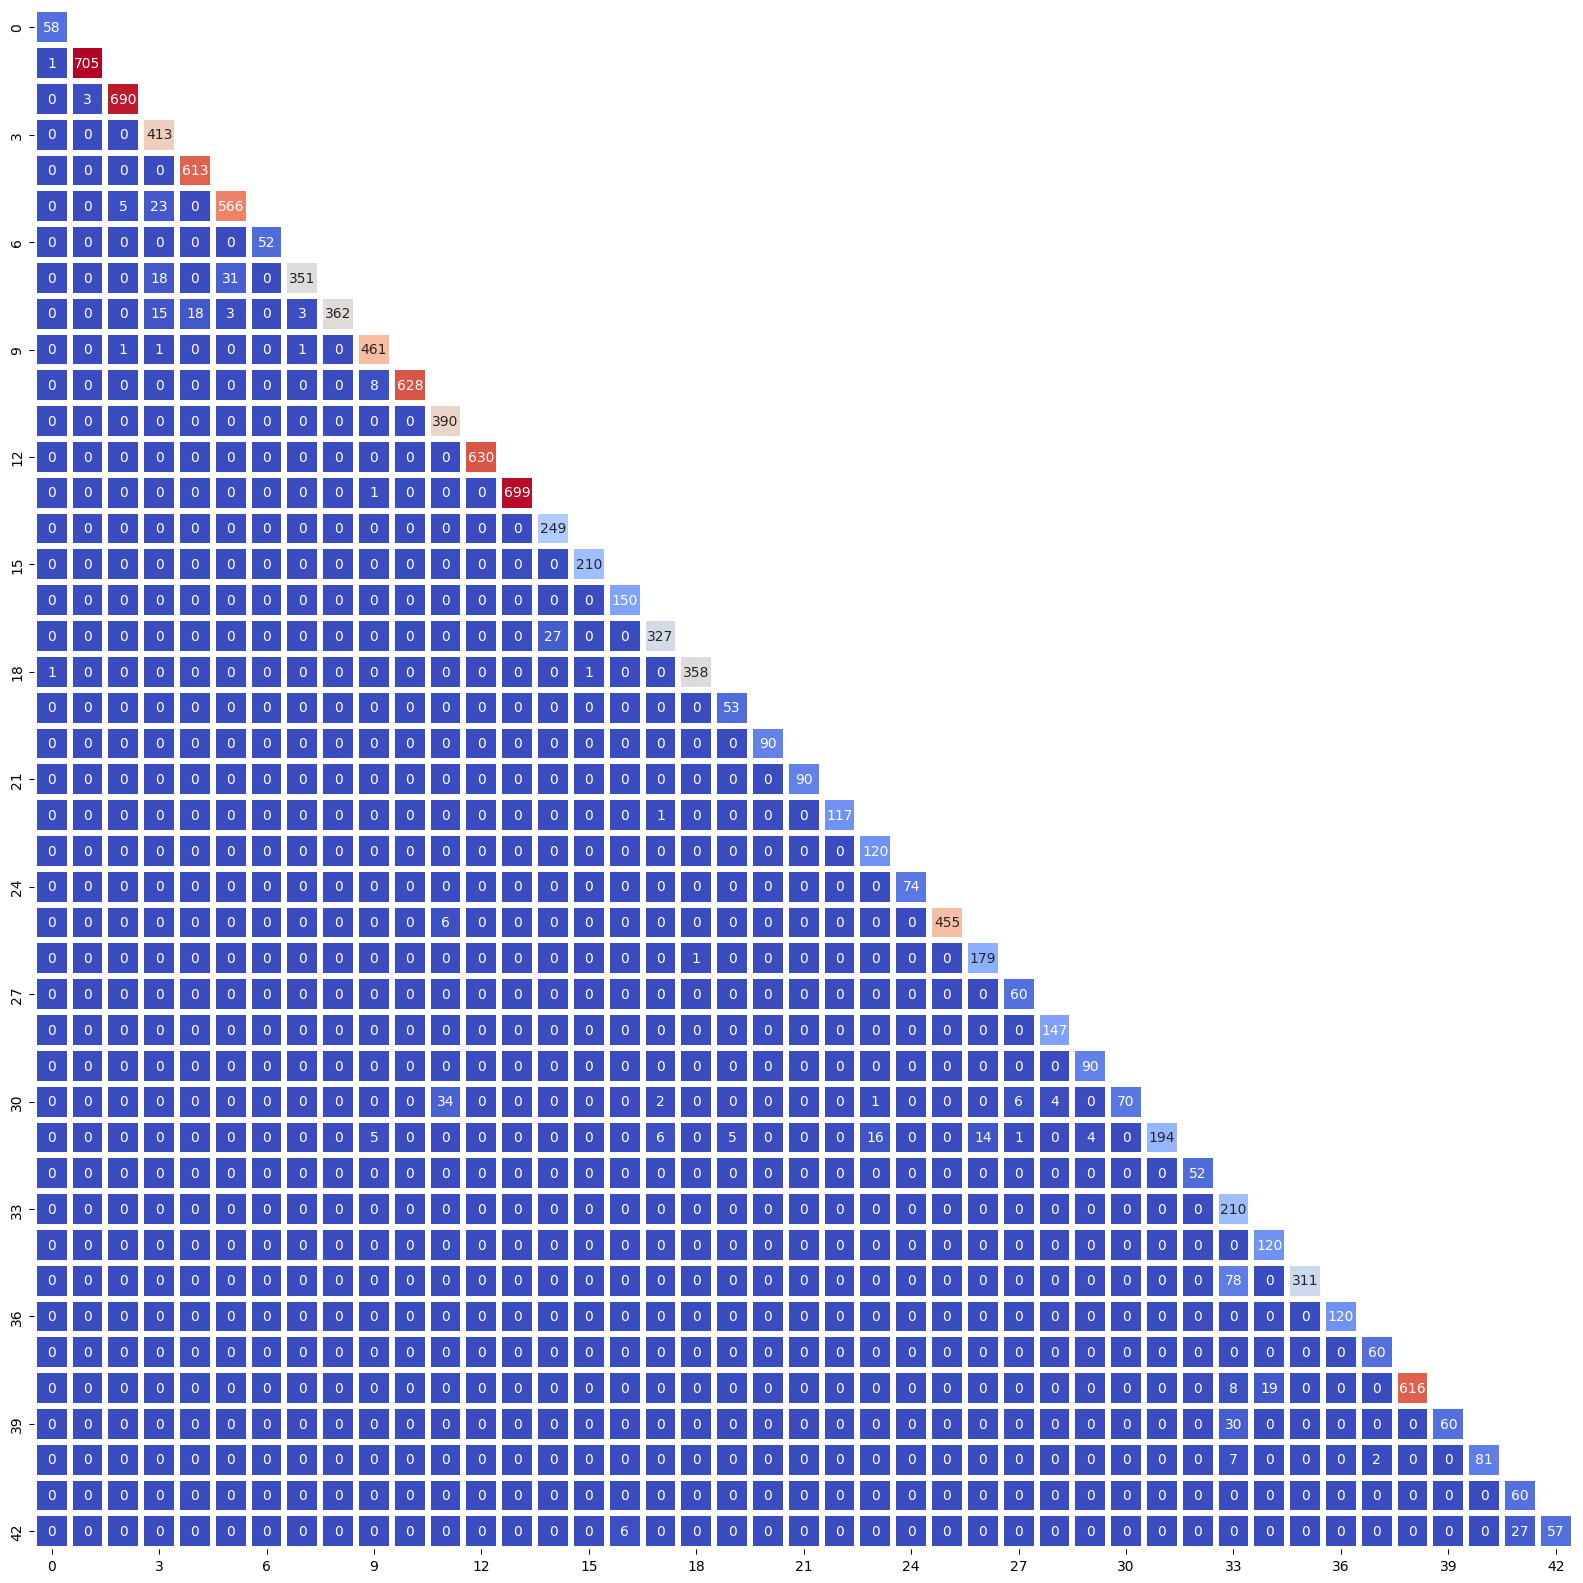

In [33]:
model.eval()
for batch in test_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    pred = torch.argmax(outputs, dim=1)

    acc.update(pred.cpu(), labels.cpu())
    recall.update(pred.cpu(), labels.cpu())
    precision.update(pred.cpu(), labels.cpu())
    confmat.update(pred.cpu(), labels.cpu())

print("Accuracy {}".format(acc.compute().item()))
print("Recall {}".format(recall.compute().item()))
print("Precision {}".format(precision.compute().item()))

matrix = confmat.compute().numpy()
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False


fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".0f",
    linewidths=3,
    cmap="coolwarm",
    ax=ax,
    cbar=False,
    xticklabels=3,
    yticklabels=3,
    square=True,
    mask=mask,
)

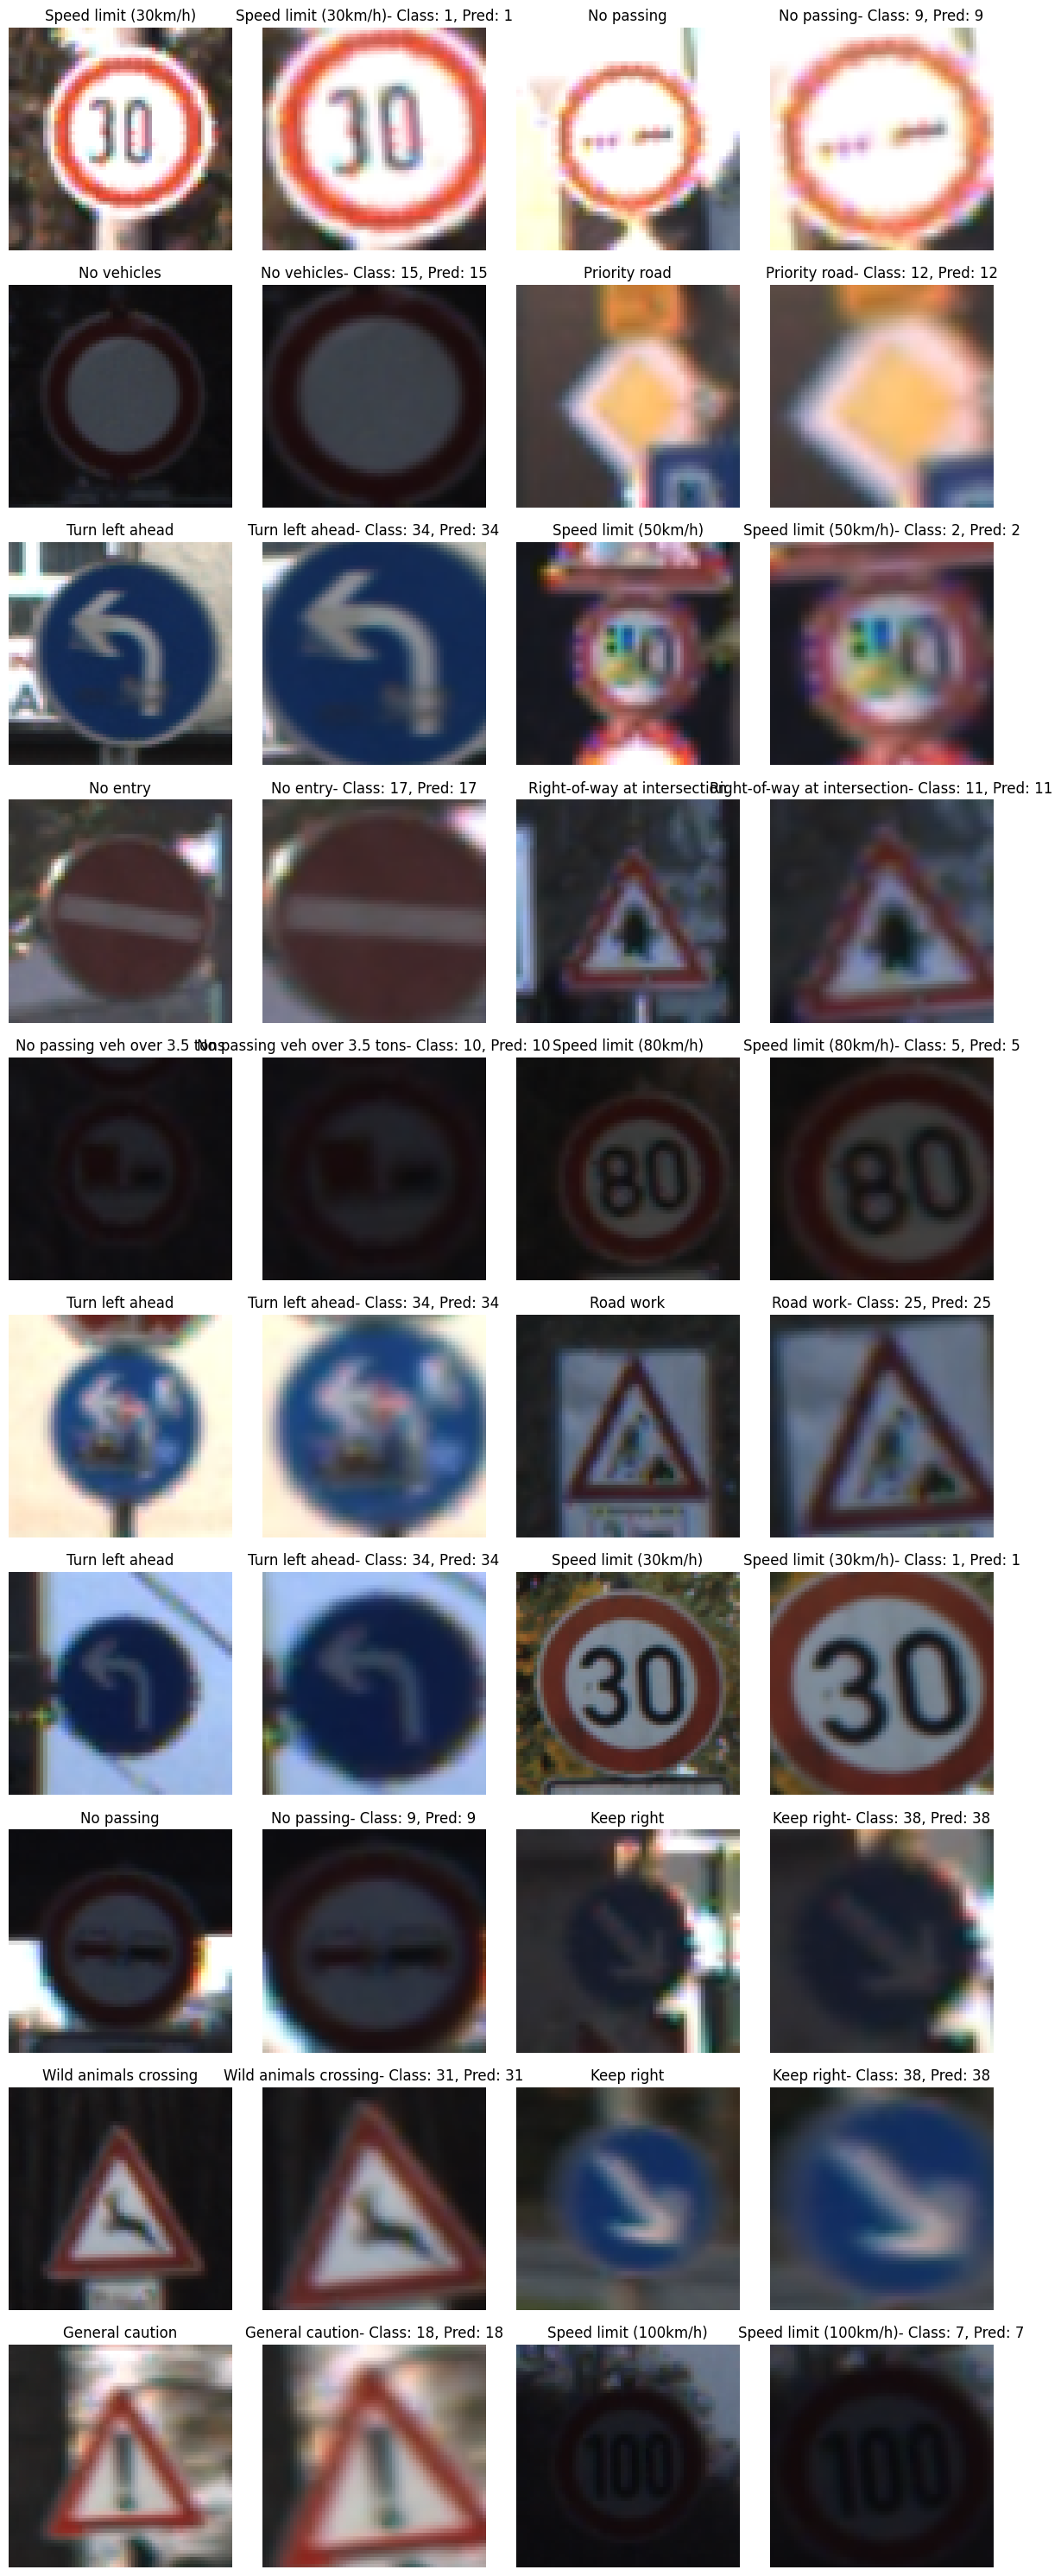

In [34]:
plt.subplots(10, 4, figsize=(12, 30))
for i in range(0, 40, 4):
    image = train_dataset[np.random.randint(len(train_dataset))]
    plt.subplot(10, 4, i + 1)
    plt.title(classes[image[1]])
    plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(10, 4, i + 2)
    result = model.stn(image[0].unsqueeze(0).to(device))
    label = model(image[0].unsqueeze(0).to(device))
    plt.title(
        classes[image[1]] + f"- Class: {image[1]}, Pred: {torch.argmax(label).item()}"
    )
    plt.imshow(result[0].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")

    image = train_dataset[np.random.randint(len(train_dataset))]
    plt.subplot(10, 4, i + 3)
    plt.title(classes[image[1]])
    plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
    plt.subplot(10, 4, i + 4)
    result = model.stn(image[0].unsqueeze(0).to(device))
    label = model(image[0].unsqueeze(0).to(device))
    plt.title(
        classes[image[1]] + f"- Class: {image[1]}, Pred: {torch.argmax(label).item()}"
    )
    plt.imshow(result[0].detach().cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
plt.tight_layout(pad=1.27)